# Earthquake predictions in Mexico (Data Wrangling)

In the last 40 years, Mexico has suffered 137 earthquakes with a magnitude of M6.0 or higher.

In 1985, with a magnitude of M8.1, one of the biggest earthquakes inside Mexican territory happened in Michoacan state and had a very big impact in Mexico city. This event accounted for more than 10,000 deaths and 30,000+ injured. Additionally, 3,000+ buildings were demolished and 100,000 more were damaged. Since then, billions of pesos have been lost and thousands of people have suffered the impact of the different earthquakes that have occurred mainly in the south and the Pacific coast (i.e. Guerrero and Oaxaca states) as well as the  center (i.e. Mexico city) areas. Coincidentally, in 2017, exactly 32 years after the event in 1985; on the same date, another earthquake of magnitude M7.1 hit Mexico city, leaving a total of 370 deaths and more than 6,000 people injured.

Due to the recurring events, the need to try to anticipate these disasters, as well as being better prepared for them, an improved response program should be developed. An early alert system based on event predictions should be part of this program. This is why we will attempt to create a reliable model utilizing the information that we have available. Our goal will be to try to estimate the time until the next big earthquake (time-to-event).

As a start, a dataset containing almost 40,000 earthquake observations from 1970 to 2022 was obtained from UNAM university data collection in Mexico (http://www2.ssn.unam.mx:8080/catalogo/).

In this step of the process, we will review the dataset that we have available.

In [1]:
#First, we import the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

from library.sb_utils import save_file

In [2]:
quakes_data = pd.read_csv('../Dataset/SSNMX_catalogo_19700101_20220319_m40_99.csv')
#We check the first few rows
quakes_data.head()

,Date,Time,Magnitude,Latitude,Longitude,Depth,Location reference,Date UTC,Time UTC,Status,State
0,1970/02/03,23:08:50,6.6,15.524,-99.493,21.0,"141 km al SUR de SAN MARCOS, GRO",1970/02/04,5:08:50,revisado,GRO
1,1970/04/29,8:01:34,7.3,14.463,-92.683,44.0,"62 km al SUROESTE de CD HIDALGO, CHIS",1970/04/29,14:01:34,revisado,CHIS
2,1970/04/30,2:32:58,6.5,14.608,-93.260,22.0,"100 km al SUROESTE de MAPASTEPEC, CHIS",1970/04/30,8:32:58,revisado,CHIS
3,1971/09/30,2:18:00,6.5,26.880,-110.800,14.0,"92 km al SUROESTE de PUEBLO YAQUI, SON",1971/09/30,8:18:00,revisado,SON
4,1972/10/20,2:17:46,6.6,18.700,-106.756,10.0,"238 km al OESTE de CIHUATLAN, JAL",1972/10/20,8:17:46,revisado,JAL


Now, we review that shape of our dataset and then we check if there are any missing values in any of the features.

In [3]:
quakes_data.shape

(39948, 11)

In [4]:
quakes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39948 entries, 0 to 39947
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                39948 non-null  object 
 1   Time                39948 non-null  object 
 2   Magnitude           39948 non-null  float64
 3   Latitude            39948 non-null  float64
 4   Longitude           39948 non-null  float64
 5   Depth               39948 non-null  float64
 6   Location reference  39948 non-null  object 
 7   Date UTC            39948 non-null  object 
 8   Time UTC            39948 non-null  object 
 9   Status              39948 non-null  object 
 10  State               39948 non-null  object 
dtypes: float64(4), object(7)
memory usage: 3.4+ MB


It seems that we don't have any missing values (NaN values). Let's make sure that this is the case.

In [5]:
quakes_data.isnull().any()

Date                  False
Time                  False
Magnitude             False
Latitude              False
Longitude             False
Depth                 False
Location reference    False
Date UTC              False
Time UTC              False
Status                False
State                 False
dtype: bool

In [6]:
quakes_data[(quakes_data.values == '')].any()

Date                  False
Time                  False
Magnitude             False
Latitude              False
Longitude             False
Depth                 False
Location reference    False
Date UTC              False
Time UTC              False
Status                False
State                 False
dtype: bool

We confirmed that in fact there are no missing values in our dataset.

We have a table of 39948 observations and 11 features. We have 4 features with a numerical value (Magnitude, Latitude, Longitude and Depth),
and 7 other which are strings. At first glance, it seems that we could drop some features that do not add much valuable information to our
purpose. Let's drop columns 'Date UTC' and 'Time UTC' and keep 'Date' and 'Time' since they have the same information but in Mexico's local time. Additionally, let's drop 'Status' column since it only indicates that the event was recorded.

In [7]:
quakes_data = quakes_data.drop(columns=['Date UTC', 'Time UTC', 'Status'])
quakes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39948 entries, 0 to 39947
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                39948 non-null  object 
 1   Time                39948 non-null  object 
 2   Magnitude           39948 non-null  float64
 3   Latitude            39948 non-null  float64
 4   Longitude           39948 non-null  float64
 5   Depth               39948 non-null  float64
 6   Location reference  39948 non-null  object 
 7   State               39948 non-null  object 
dtypes: float64(4), object(4)
memory usage: 2.4+ MB


Now we check the data to confirm if we have any duplicate values.

In [8]:
quakes_data.duplicated().any()

False

At first glance, it seems that we don't have any duplicated values, but let's dig a little deeper to make sure of this.<br>
We will create a new column in the dataset which contains Date and Time concatenated as a full datetime value. After that we will check again if there are no duplicates in this column.

In [9]:
#Since both variables (Date and Time) are strings, we only apply the method pd.to_datetime()
quakes_data['Date_Time'] = pd.to_datetime(quakes_data.Date + ' ' + quakes_data.Time)

Let's check our dataframe with this new column and confirm if it is in the correct format.

In [10]:
quakes_data.head()

,Date,Time,Magnitude,Latitude,Longitude,Depth,Location reference,State,Date_Time
0,1970/02/03,23:08:50,6.6,15.524,-99.493,21.0,"141 km al SUR de SAN MARCOS, GRO",GRO,1970-02-03 23:08:50
1,1970/04/29,8:01:34,7.3,14.463,-92.683,44.0,"62 km al SUROESTE de CD HIDALGO, CHIS",CHIS,1970-04-29 08:01:34
2,1970/04/30,2:32:58,6.5,14.608,-93.260,22.0,"100 km al SUROESTE de MAPASTEPEC, CHIS",CHIS,1970-04-30 02:32:58
3,1971/09/30,2:18:00,6.5,26.880,-110.800,14.0,"92 km al SUROESTE de PUEBLO YAQUI, SON",SON,1971-09-30 02:18:00
4,1972/10/20,2:17:46,6.6,18.700,-106.756,10.0,"238 km al OESTE de CIHUATLAN, JAL",JAL,1972-10-20 02:17:46


In [11]:
quakes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39948 entries, 0 to 39947
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                39948 non-null  object        
 1   Time                39948 non-null  object        
 2   Magnitude           39948 non-null  float64       
 3   Latitude            39948 non-null  float64       
 4   Longitude           39948 non-null  float64       
 5   Depth               39948 non-null  float64       
 6   Location reference  39948 non-null  object        
 7   State               39948 non-null  object        
 8   Date_Time           39948 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), object(4)
memory usage: 2.7+ MB


In [12]:
#Let's check if the new 'Date_Time' column has any duplicates
quakes_data['Date_Time'].duplicated().sum()

11

In [13]:
quakes_data[quakes_data['Date_Time'].duplicated()]

,Date,Time,Magnitude,Latitude,Longitude,Depth,Location reference,State,Date_Time
5519,1994/12/22,4:38:20,4.3,16.6300,-99.9200,5.0,"27 km al SUR de ACAPULCO, GRO",GRO,1994-12-22 04:38:20
6343,1996/07/04,6:42:20,4.6,16.2100,-97.7300,15.0,"37 km al SURESTE de PINOTEPA NACIONAL, OAX",OAX,1996-07-04 06:42:20
6348,1996/07/07,1:47:31,4.5,16.1900,-99.5200,43.0,"68 km al SUR de SAN MARCOS, GRO",GRO,1996-07-07 01:47:31
6350,1996/07/07,2:23:31,4.0,16.3000,-100.3100,33.0,"77 km al SUROESTE de ACAPULCO, GRO",GRO,1996-07-07 02:23:31
6360,1996/07/11,2:46:17,4.4,15.7000,-96.6300,5.0,"18 km al SUROESTE de S PEDRO POCHUTLA, OAX",OAX,1996-07-11 02:46:17
16587,2011/11/01,6:31:58,6.0,19.7400,-109.3100,15.0,"354 km al SUR de CABO SAN LUCAS, BCS",BCS,2011-11-01 06:31:58
20145,2015/03/10,21:56:46,4.0,25.8563,-110.2520,10.0,"108 km al OESTE de AHOME, SIN",SIN,2015-03-10 21:56:46
21334,2015/11/19,7:24:06,4.2,15.1553,-94.5492,17.8,"133 km al SURESTE de SALINA CRUZ, OAX",OAX,2015-11-19 07:24:06
39120,2021/11/26,3:45:11,4.0,18.2000,-100.4700,49.0,"23 km al SUROESTE de ARCELIA, GRO",GRO,2021-11-26 03:45:11
39122,2021/11/26,3:51:02,4.0,17.2100,-100.9300,31.0,"32 km al OESTE de TECPAN, GRO",GRO,2021-11-26 03:51:02


In [14]:
quakes_data[quakes_data['Date_Time'] == '2011-11-01 06:31:58']

,Date,Time,Magnitude,Latitude,Longitude,Depth,Location reference,State,Date_Time
16586,2011/11/01,6:31:58,6.0,19.73,-109.30,16.0,"355 km al SUR de CABO SAN LUCAS, BCS",BCS,2011-11-01 06:31:58
16587,2011/11/01,6:31:58,6.0,19.74,-109.31,15.0,"354 km al SUR de CABO SAN LUCAS, BCS",BCS,2011-11-01 06:31:58


Just as we thought, we had some rows duplicated in date and time. The reason why we couldn't identify them when using the duplicated() method in the entire dataframe is because, as we can see in the example above, the date and time values are the same, but the values in other columns are a little different.
Now that we are confident that we found all the duplicates, let's drop them.

In [15]:
quakes_data.drop_duplicates(subset='Date_Time', inplace=True)

There are no duplicate values in our set so we can proceed to the next step.

Let's add now 3 more columns to the dataset: 'Year', 'Month' and 'Day'. These 3 columns will enable us to later group our information and get more insights from it.

In [16]:
quakes_data['Year'] = pd.to_datetime(quakes_data['Date']).dt.year
quakes_data['Month'] = pd.to_datetime(quakes_data['Date']).dt.month
quakes_data['Day'] = pd.to_datetime(quakes_data['Date']).dt.day
quakes_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39937 entries, 0 to 39947
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                39937 non-null  object        
 1   Time                39937 non-null  object        
 2   Magnitude           39937 non-null  float64       
 3   Latitude            39937 non-null  float64       
 4   Longitude           39937 non-null  float64       
 5   Depth               39937 non-null  float64       
 6   Location reference  39937 non-null  object        
 7   State               39937 non-null  object        
 8   Date_Time           39937 non-null  datetime64[ns]
 9   Year                39937 non-null  int64         
 10  Month               39937 non-null  int64         
 11  Day                 39937 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(4)
memory usage: 4.0+ MB


Now let's reorder the columns on our dataframe for better visualization. Additionally, let's drop 'Date' and 'Time' columns because we won't need them, since we already have the 'Date_Time' column.

In [17]:
cols = ['Date_Time', 'Year', 'Month', 'Day', 'Magnitude', 'Latitude', 'Longitude', 'Depth', 'Location reference', 'State']
quakes_data = quakes_data[cols]

In [18]:
quakes_data.head()

,Date_Time,Year,Month,Day,Magnitude,Latitude,Longitude,Depth,Location reference,State
0,1970-02-03 23:08:50,1970,2,3,6.6,15.524,-99.493,21.0,"141 km al SUR de SAN MARCOS, GRO",GRO
1,1970-04-29 08:01:34,1970,4,29,7.3,14.463,-92.683,44.0,"62 km al SUROESTE de CD HIDALGO, CHIS",CHIS
2,1970-04-30 02:32:58,1970,4,30,6.5,14.608,-93.260,22.0,"100 km al SUROESTE de MAPASTEPEC, CHIS",CHIS
3,1971-09-30 02:18:00,1971,9,30,6.5,26.880,-110.800,14.0,"92 km al SUROESTE de PUEBLO YAQUI, SON",SON
4,1972-10-20 02:17:46,1972,10,20,6.6,18.700,-106.756,10.0,"238 km al OESTE de CIHUATLAN, JAL",JAL


In [19]:
quakes_data.shape

(39937, 10)

We eliminated in total 11 duplicated rows and rearranged the 10 columns we have.<br>
Now, for the next step, let's try to get some initial insights from this data.

Let's get some information on which locations (States) are the ones with more events in history (since 1970).

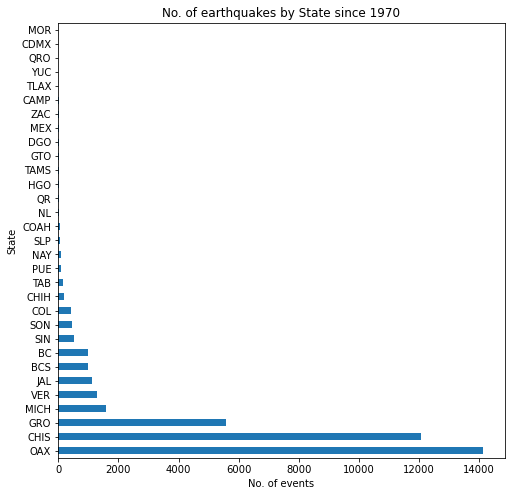

In [20]:
quakes_data.groupby('State')[['State']].value_counts().sort_values(ascending=False).plot(
    kind='barh', figsize=(8, 8), title='No. of earthquakes by State since 1970')
plt.xlabel('No. of events');

Clearly the states of Oaxaca, Chiapas and Guerrero are the ones with more seismic activity in the mexican territory.
This is no surprise since they are located in the Pacific coast on top of the Cocos and Rivera plates.

Now, we do a similar plot but this time to check the number of events by year.

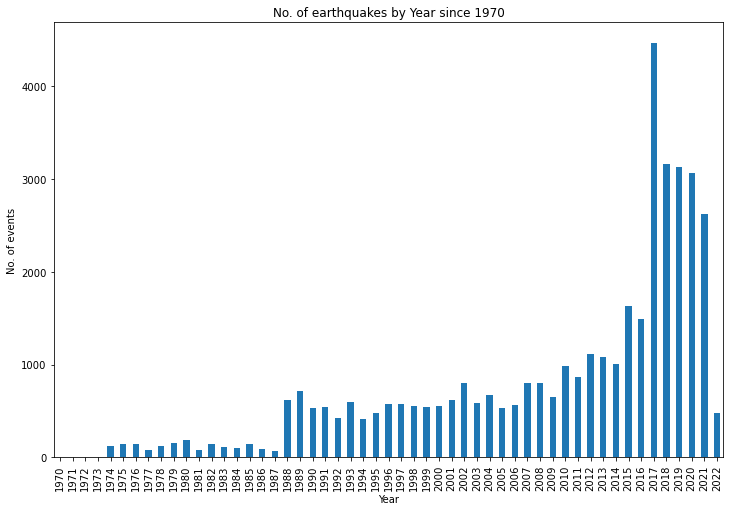

In [21]:
quakes_data.groupby('Year')[['Year']].value_counts().plot(
    kind='bar', figsize=(12, 8), title='No. of earthquakes by Year since 1970')
plt.ylabel('No. of events');

In this case, we see that since 2017, the number of registered earthquakes have increased considerably. But this may be due to a change in recording method, or technology improvement or any other unrelated reason to a real increase in the number of events. For now, we will leave this information as it is.

As a next step, let's check the distribution of the Magnitude of the events by State.

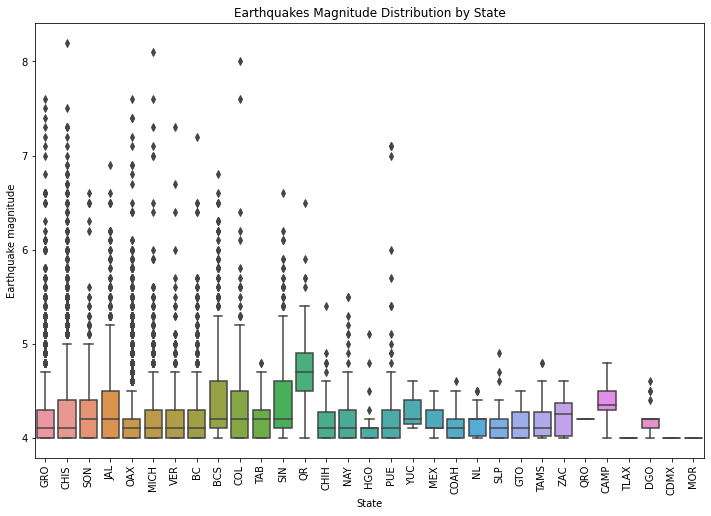

In [22]:
plt.subplots(figsize=(12, 8))
sns.boxplot(x='State', y='Magnitude', data=quakes_data)
plt.xticks(rotation='vertical')
plt.title('Earthquakes Magnitude Distribution by State')
plt.ylabel('Earthquake magnitude')
plt.xlabel('State');

Here we can confirm again that most of the states located in the Pacific coast are the ones that have the most events with higher Magnitude. It may be good idea to analyze these states more in detail during the Exploratory Analysis.

Now we make a summary table grouped by state and showing the different magnitude values of the events in separate columns.

In [23]:
summary_st_mag = quakes_data.groupby(by='State')['Date_Time'].count().to_frame()
summary_st_mag.rename(columns={'Date':'Total_events'}, inplace=True)
summary_st_mag['M4_to_M5']=quakes_data.groupby(by='State')['Magnitude'].apply(lambda x: ((x>=4.0)& (x<5.0)).sum())
summary_st_mag['M5_to_M6']=quakes_data.groupby(by='State')['Magnitude'].apply(lambda x: ((x>=5.0)& (x<6.0)).sum())
summary_st_mag['Higher_than_M6']=quakes_data.groupby(by='State')['Magnitude'].apply(lambda x: (x>=6.0).sum())
summary_st_mag.reset_index().head()

,State,Date_Time,M4_to_M5,M5_to_M6,Higher_than_M6
0,BC,972,917,50,5
1,BCS,993,867,110,16
2,CAMP,10,10,0,0
3,CDMX,1,1,0,0
4,CHIH,186,185,1,0


Also, we make a summary table grouped by Month and showing the average and max magnitudes for the respective month.

In [24]:
summary_mth_mag = quakes_data.groupby(['Year', 'Month'])['Date_Time'].count().to_frame()
summary_mth_mag.rename(columns={'Date':'Total_events'}, inplace=True)
summary_mth_mag['Avg_Magnitude'] = quakes_data.groupby(['Year', 'Month'])[['Magnitude']].mean()
summary_mth_mag['Max_Magnitude'] = quakes_data.groupby(['Year', 'Month'])[['Magnitude']].max()
summary_mth_mag.reset_index().head()

,Year,Month,Date_Time,Avg_Magnitude,Max_Magnitude
0,1970,2,1,6.6,6.6
1,1970,4,2,6.9,7.3
2,1971,9,1,6.5,6.5
3,1972,10,1,6.6,6.6
4,1972,11,1,6.5,6.5


Finally, we have 3 tables with the information we need to proceed into the next step.
We just need to save the sets we created.

In [25]:
#Save the quakes_data set
datapath = '../derived_data/'
quakes_data.to_csv(datapath+'quakes_data_cleaned.csv')

In [26]:
#Save the summary_st_mag set
datapath = '../derived_data/'
summary_st_mag.to_csv(datapath+'summary_st_mag.csv')

In [27]:
#Save the summary_mth_mag set
datapath = '../derived_data/'
summary_mth_mag.to_csv(datapath+'summary_mth_mag.csv')